<font size="10">Sentiment Analysis and Natural Language Processing</font>

<font size="2">Charles Rowe, ID# 006539689, WGU D213 Advanced Data Analytics, Task 2</font>

<font size="6">A1: Research Question</font>

Using the provided texts, how accurately can an NLP model predict the sentiment of future text.

<font size='6'>A2: Objectives or Goals</font>

The goals of this analysis are as follows:
<ul>
<li>Concatenate provided texts into one dataframe</li>
<li>Tokenize sentences</li>
<li>Split unique words (minus stop words) into a bag-of-words</li>
<li>Split data into training, testing, and validation sets</li>
<li>Create sequential keras model for sentiment analysis</li>
<li>Evaluate accuracy of model</li>
</ul>


<font size='6'>A3: Prescribed Network</font>

For this analysis, I will be using a Recurrent Neural Network (RNN). RNN networks are useful for language processing and speech recognition as it loops through sequential data to learn for better accuracy.

<font size='6'>B1: Data Exploration</font>

To begin, I will need to import the libraries that will be needed for the analysis, concatenate the provided datasets, and make sure that there are no null reviews or labels.

In [ ]:
import random
random.seed(1987)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import string
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Embedding, Input
from tensorflow.keras.models import Sequential
from nltk import word_tokenize, sent_tokenize
import nltk.corpus
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
tf.config.run_functions_eagerly(True)
pd.set_option("display.max_columns", None)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cgrow\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\cgrow\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cgrow\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cgrow\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
imdb_db_full = pd.read_csv('imdb_labelled.txt', sep='\t')
amazon_db_full = pd.read_csv('amazon_cells_labelled.txt', sep='\t')
yelp_db_full = pd.read_csv('yelp_labelled.txt', sep='\t')

full_db = pd.concat((imdb_db_full,amazon_db_full,yelp_db_full), ignore_index=True)
full_db.to_csv('full_db.csv')
n_cols = full_db.shape[1]

reviews = full_db['review']
labels = full_db['label']

print(reviews)
print(labels)

0       A very, very, very slow-moving, aimless movie ...
1       Not sure who was more lost - the flat characte...
2       Attempting artiness with black & white and cle...
3            Very little music or anything to speak of.  
4       The best scene in the movie was when Gerardo i...
                              ...                        
2995    I think food should have flavor and texture an...
2996                             Appetite instantly gone.
2997    Overall I was not impressed and would not go b...
2998    The whole experience was underwhelming, and I ...
2999    Then, as if I hadn't wasted enough of my life ...
Name: review, Length: 3000, dtype: object
0       0
1       0
2       0
3       0
4       1
       ..
2995    0
2996    0
2997    0
2998    0
2999    0
Name: label, Length: 3000, dtype: int64


In [3]:
review_text = np.asarray(reviews)
review_text = review_text[~pd.isnull(review_text)]
print(f"There are {len(review_text)} reviews.")

There are 3000 reviews.


In [4]:
rev_labels = np.asarray(labels)
rev_labels = rev_labels[~pd.isnull(rev_labels)]
print(f"There are {len(rev_labels)} labels.")

There are 3000 labels.


As shown, there are no null reviews or labels. I will now check for presence of unusual characters.

In [5]:
import demoji

emojis = [demoji.findall(review.lower()) for review in review_text]

print(emojis)

[{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {},

There are no emojis.

Non-English characters:

(Below uses code from [Ednalyn C. De Dios](https://github.com/ecdedios/d213-advanced-data-analytics/blob/main/task2/notebooks/D213%20Performance%20Assessment%20Task%202%20(Rev.%200)-Copy2.ipynb), 2023)

In [6]:
def isEnglish(c):
    try:
        c.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

non_english = []
for index, row in full_db.iterrows():
    for l in list(row['review']):
        for c in l:
            if isEnglish(c) == True:
                pass
            else:
                non_english.append(c)
non_english[:10]


['\x96', 'é', '\x85', '\x96', 'é', 'é', 'å', '\x96', '\x97', '\x96']

There are non-english characters. I will now check for the vocabulary size.

In [7]:
import unicodedata
import re

def clean_sentence(sentence):
    stops = nltk.corpus.stopwords.words('english') + list(string.punctuation) + ['...',' - ', 'ca', 'wo', "'s", "'ing","'ll", "'re"]
    negation = ['but', 'not', "don't", "aren't", "couldn't", "doesn't", "hadn't", "hasn't", "haven't", 
                  "isn't", "shouldn't", "wouldn't"]
    for word in negation:
        stops.remove(word)
    sentence = (unicodedata.normalize('NFKD', sentence)
        .encode('ascii', 'ignore')
        .decode('utf-8', 'ignore')
        .lower())
    words = re.sub(r'[^\w\s]', '', sentence).split()
    word_list = [word for word in words if word not in stops]
    return word_list

def get_words(df, column):
    return clean_sentence(''.join(str(df[column].tolist())))

In [8]:
all_words = get_words(full_db, 'review')
all_freq = pd.Series(all_words).value_counts()

vocab_size = len(all_freq)
print('Vocabulary size: ' + str(vocab_size))

Vocabulary size: 5279


Now to find the word embedding length and the maximum sequence length.

In [9]:
max_sequence_embedding = int(round(np.sqrt(np.sqrt(vocab_size)), 0))
print('Max sequence embedding: ' + str(max_sequence_embedding))

Max sequence embedding: 9


In [10]:
list_of_lens = []
for index, row in full_db.iterrows():
    list_of_lens.append(len(clean_sentence(row['review'])))
sequence_length = max(list_of_lens)
print('Sequence length: ' + str(sequence_length))

Sequence length: 41


Summary:


Regex and the demoji library were used to find and handle non-english characters.<br>
Vocabulary size is 5279. This was done by the value_counts() method after handling non-english characters and removing stopwords.<br>
The proposed word embedding length is 9, which was found by using the fourth root of the vocabulary size. (As recommended by [Google](https://developers.googleblog.com/en/introducing-tensorflow-feature-columns/))<br>
Maximum sequence length is 41. This was found by calculating lengths of sequences.<br>


<font size='6'>B2: Tokenization</font>

Tokenization is the process of breaking down texts into individual words or characters. For this analysis, it would be better to tokenize into individual words. After tokenization is initiailized, we can run tokens through a list and iterate a bag-of-words to find the final vocabulary size to feed into the model.

In [ ]:
sentence_tokens = [sent_tokenize(review.lower()) for review in review_text]
print(f'Tokenized into {len(sentence_tokens)} elements.')
sentence_tokens[0]

Tokenized into 3000 elements.


['a very, very, very slow-moving, aimless movie about a distressed, drifting young man.']

In [ ]:
stopwords = nltk.corpus.stopwords.words('english') + list(string.punctuation) + ['...',' - ', 'ca', 'wo', "'s", "'ing","'ll", "'re"]

word_tokens = []

for sentences in sentence_tokens:
    temporary_list = []

    if (len(sentences)) == 1:
        words_in_sentence = word_tokenize(sentences[0])
        for word in words_in_sentence:
            if word == "n't":
                word = "not"
            temporary_list.append(word)
    else:
        num_sentences = len(sentences)

        for i in range(0, num_sentences):
            words_in_sentence = word_tokenize(sentences[i])
            for word in words_in_sentence:
                if word == "n't":
                    word = "not"
                temporary_list.append(word)

    if len(temporary_list) == 0:
        temporary_list = ['empty']

    trimmed_words = [word for word in temporary_list if word not in stopwords]
    word_tokens.append(trimmed_words)

In [ ]:
i = 0 
bag_of_words = []
max_review_length = 0

for words in word_tokens:
    if len(words) > max_review_length:
        max_review_length = len(words)
        print(f"Max length: {max_review_length} word tokens.")
    for word in words:
        bag_of_words.append(word)
    i += 1 

unique_words = set(bag_of_words)
num_uniq_words = len(unique_words)
print(f"Words: {len(bag_of_words)} \nUnique Words: {num_uniq_words} \nMaximum number of words: {max_review_length}")

Max length: Index 0 contains 7 word tokens.
Max length: Index 1 contains 8 word tokens.
Max length: Index 2 contains 18 word tokens.
Max length: Index 42 contains 22 word tokens.
Max length: Index 243 contains 27 word tokens.
Max length: Index 390 contains 39 word tokens.
Max length: Index 620 contains 41 word tokens.
Words: 18518 
Unique Words: 5204 
Maximum number of words: 41


In [15]:
word_tokens[621]

['mature',
 'subtle',
 'script',
 'suggests',
 'occasionally',
 'brings',
 'dramatic',
 'focus',
 'underlying',
 'tensions',
 'well',
 'served',
 'perfect',
 'performances',
 'apart',
 'odd',
 'inappropriate',
 'smiling',
 'keira',
 'knightley',
 'prone',
 'though',
 'perhaps',
 'direction',
 'time',
 'characters',
 'often',
 'mention']

In [16]:
row_list = []
i = 0

for i in range(0, len(word_tokens)):
    temp_dict = {}
    temp_string = ""
    for word in word_tokens[i]:
        temp_string = temp_string + word + " "
    temp_dict.update({"recommended" : rev_labels[i]})
    temp_dict.update({"review_text" : temp_string})
    row_list.append(temp_dict)
    i += 1

new_df = pd.DataFrame(row_list)
rows_to_drop = np.where(new_df['recommended'] == 'label')
rows_to_drop

new_df = new_df.drop([0,1001,2002])

In [17]:
X = new_df['review_text']
y = new_df['recommended']

X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, train_size=.7, random_state = 1987)
X_valid, X_test, y_valid, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state = 1987) 

In [18]:
tokenizer = Tokenizer(num_words= 5000, lower= False)
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocab is {vocab_size} elements long.")

word_index = tokenizer.word_index
word_index


Vocab is 4116 elements long.


{'good': 1,
 'great': 2,
 'movie': 3,
 'phone': 4,
 'film': 5,
 'one': 6,
 'like': 7,
 'service': 8,
 'food': 9,
 'time': 10,
 'place': 11,
 'bad': 12,
 'really': 13,
 'would': 14,
 'well': 15,
 'ever': 16,
 'best': 17,
 'even': 18,
 'back': 19,
 'go': 20,
 'also': 21,
 "'ve": 22,
 'product': 23,
 'could': 24,
 "''": 25,
 'love': 26,
 'made': 27,
 'nice': 28,
 'work': 29,
 'quality': 30,
 'see': 31,
 'first': 32,
 'use': 33,
 'excellent': 34,
 'get': 35,
 "'m": 36,
 'sound': 37,
 'better': 38,
 'recommend': 39,
 'battery': 40,
 'much': 41,
 'never': 42,
 'works': 43,
 'way': 44,
 'headset': 45,
 'think': 46,
 'make': 47,
 '10': 48,
 'worst': 49,
 'got': 50,
 'acting': 51,
 'characters': 52,
 'everything': 53,
 'disappointed': 54,
 'still': 55,
 '2': 56,
 'say': 57,
 'movies': 58,
 'price': 59,
 'real': 60,
 'enough': 61,
 'thing': 62,
 'experience': 63,
 'minutes': 64,
 'right': 65,
 'terrible': 66,
 'case': 67,
 'ear': 68,
 'money': 69,
 'definitely': 70,
 'people': 71,
 'seen': 72,
 

Tokenization is complete. Vocab length of the training set is 4116 words.

In [19]:
X_train_seqs = tokenizer.texts_to_sequences(X_train)
X_train_pad = pad_sequences(X_train_seqs, maxlen=max_review_length, padding='post')
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_review_length, padding='post')
X_val_seq = tokenizer.texts_to_sequences(X_valid)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_review_length, padding='post')

In [20]:
print(f"The shape of the padded reviews within the training set is {X_train_pad.shape}")
print(X_train_pad)

The shape of the padded reviews within the training set is (2097, 41)
[[  91 1635  708 ...    0    0    0]
 [ 112   81 1014 ...    0    0    0]
 [   6  282  709 ...    0    0    0]
 ...
 [  26    2 4114 ...    0    0    0]
 [   8    1  290 ...    0    0    0]
 [   4  531 4115 ...    0    0    0]]


In [21]:
print(f"The shape of the padded reviews within the training set is {y_train.shape}")
print(y_train)
print(y_train.unique())

The shape of the padded reviews within the training set is (2097,)
521     0
2155    1
2766    1
2715    1
2827    0
       ..
1608    0
747     1
1957    1
2577    1
1518    1
Name: recommended, Length: 2097, dtype: int64
[0 1]


In [22]:
new_df.to_csv('task2.csv')

In [23]:
model = Sequential()
model.add(Input(shape=[8]))
model.add(Embedding(input_dim= vocab_size, output_dim= 8, input_length = max_review_length))
model.add(Dense(150, activation = "relu"))
model.add(Dense(75, activation = "relu"))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer= 'adam', loss= 'binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 8, 8)           │        32,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8, 150)         │         1,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8, 75)          │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8, 1)           │            76 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,679 (178.43 KB)

 Trainable params: 45,679 (178.43 KB)

 Non-trainable params: 0 (0.00 B)

None


In [24]:
num_classes = 41
y_train = to_categorical(y_train, num_classes=num_classes)
print(y_train.shape)
y_valid = to_categorical(y_valid, num_classes=num_classes)
print(y_valid.shape)
early_stop_check = EarlyStopping(monitor='val_accuracy', patience=3)
results = model.fit(X_train_pad, y_train, validation_data = (X_val_pad, y_valid), epochs=15, callbacks=early_stop_check)

(2097, 41)
(450, 41)
Epoch 1/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9711 - loss: 0.3485 - val_accuracy: 0.9756 - val_loss: 0.0684
Epoch 2/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9756 - loss: 0.0685 - val_accuracy: 0.9756 - val_loss: 0.0670
Epoch 3/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9756 - loss: 0.0659 - val_accuracy: 0.9756 - val_loss: 0.0679
Epoch 4/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9756 - loss: 0.0598 - val_accuracy: 0.9754 - val_loss: 0.0720


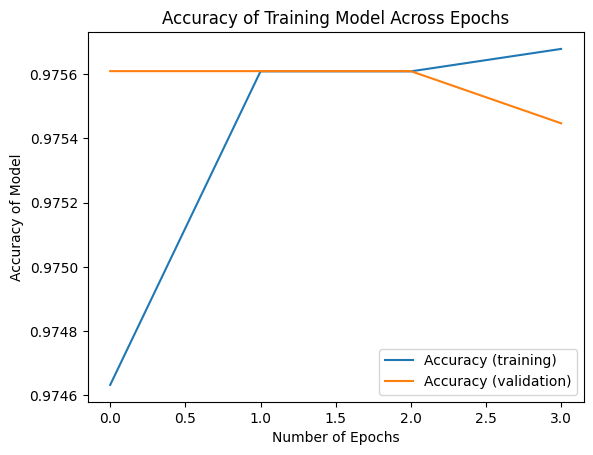

In [25]:
plt.plot(results.history['accuracy'], label= "Accuracy (training)")
plt.plot(results.history['val_accuracy'], label= "Accuracy (validation)")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy of Model")
plt.legend()
plt.title("Accuracy of Training Model Across Epochs")
plt.show()

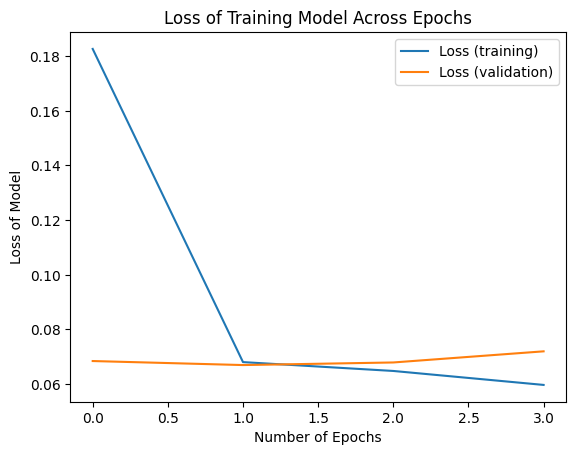

In [26]:
plt.plot(results.history['loss'], label= "Loss (training)")
plt.plot(results.history['val_loss'], label= "Loss (validation)")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss of Model")
plt.legend()
plt.title("Loss of Training Model Across Epochs")
plt.show()

In [27]:
y_test = to_categorical(y_test, num_classes=num_classes)
print(y_test.shape)
model.evaluate(X_test_pad, y_test)

(450, 41)
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9755 - loss: 0.0717


[0.07226204872131348, 0.9753929972648621]

In [28]:
#model.save('Task2Model.keras')